In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import yfinance as yf
import os

In [15]:
os.makedirs("data", exist_ok=True)
rolling_analysis_path = "analysis_data/pe_pb_ratio_rolling_analysis.csv"
df = pd.read_csv(rolling_analysis_path, parse_dates=['Date'])


In order to ensure all values are numeric, errors="coerce" converts non numeric values to Nan. We are doing this to avoid errors during cumulative returns calculation.

In [16]:

sp500_path = "data/sp500.csv"
if not os.path.exists(sp500_path):
    sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-12-31")
    sp500.reset_index(inplace=True)
    sp500.to_csv(sp500_path, index=False)
    print("S&P Data Downloaded")
else:
    sp500 = pd.read_csv(sp500_path, parse_dates=['Date'])

sp500['Close'] = pd.to_numeric(sp500['Close'], errors='coerce')
sp500 = sp500.dropna(subset=['Close'])


Sorting and Computing S&P 500 returns

In [17]:
sp500 = sp500.sort_values('Date').reset_index(drop=True)
sp500['Return'] = sp500['Close'].pct_change().fillna(0)
sp500['Cumulative'] = (1 + sp500['Return']).cumprod()
initial_capital = 100000
sp500['SP500_Curve'] = initial_capital * sp500['Cumulative']

tickers = df['TickerName'].unique()
rolling_windows = df['RollingWindow'].unique()

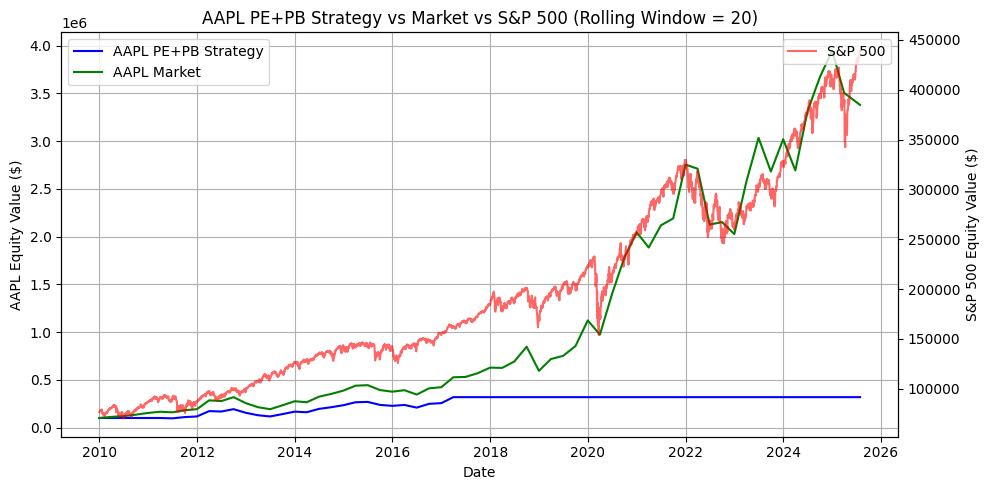

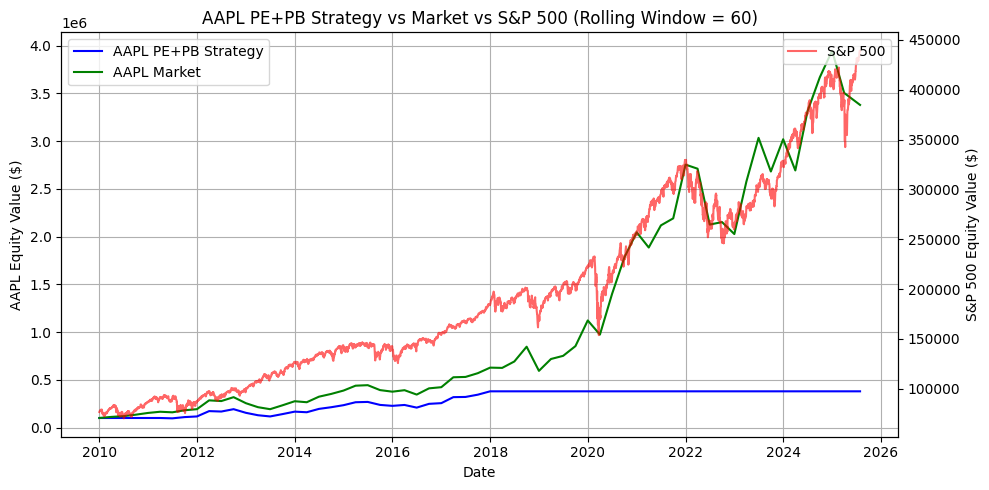

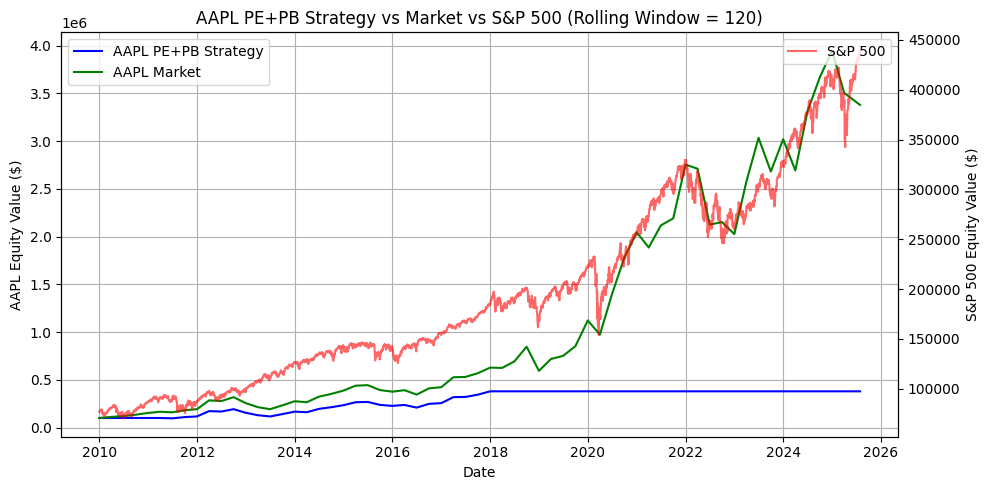

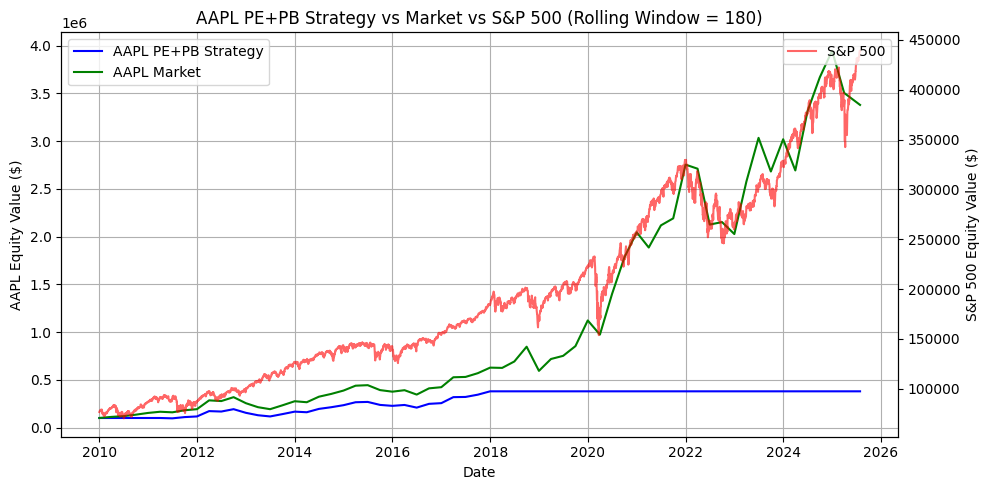

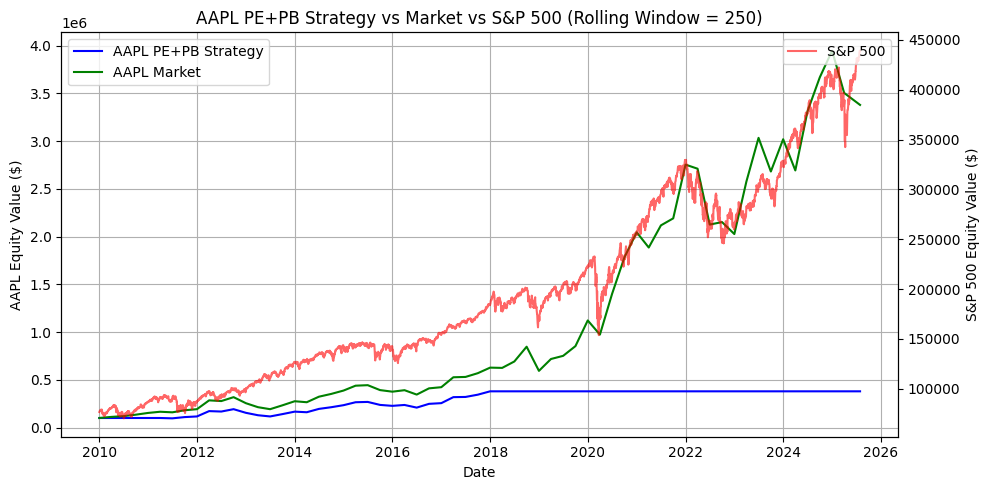

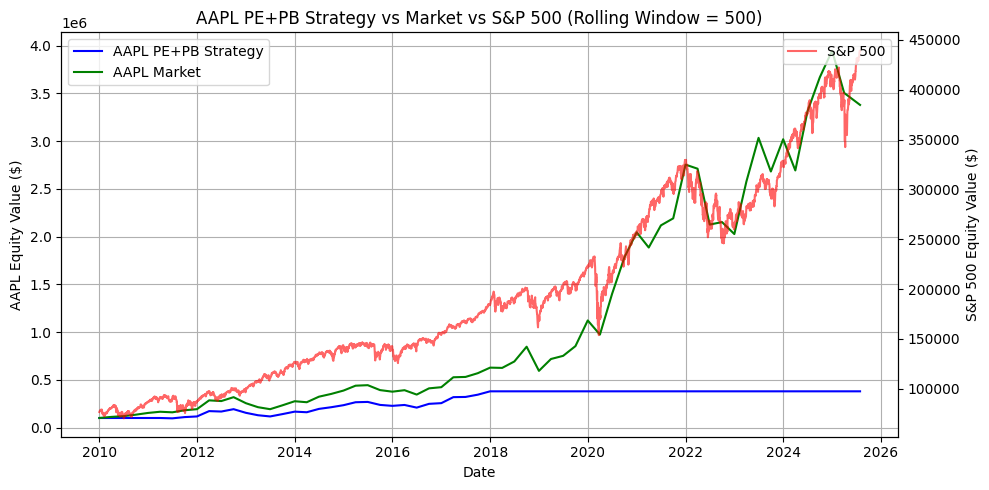

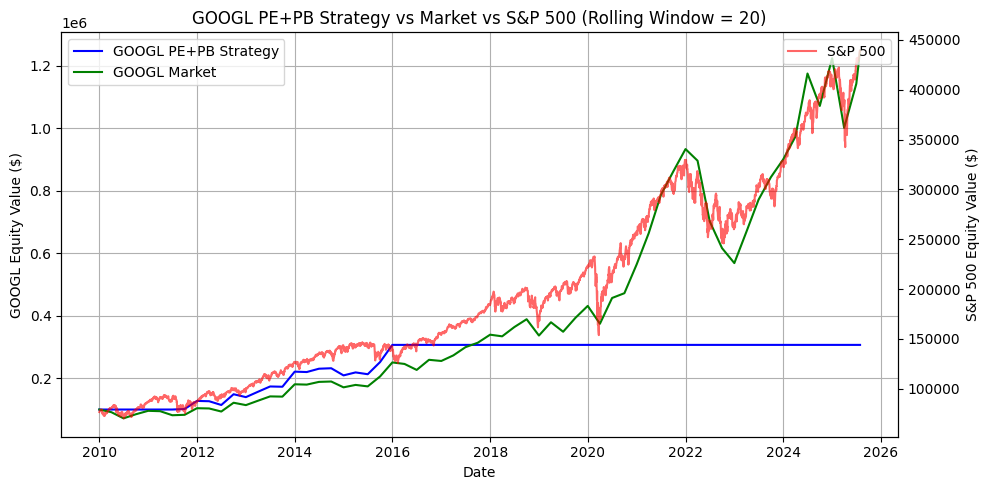

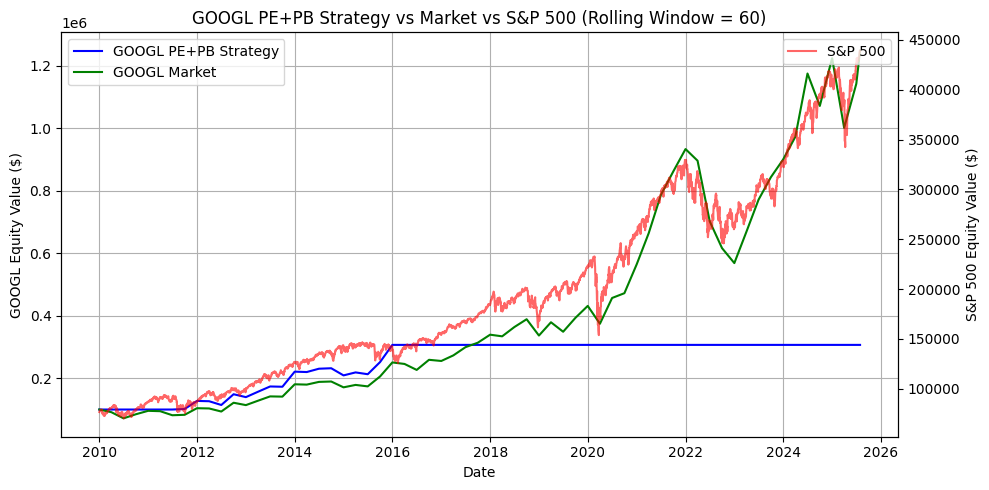

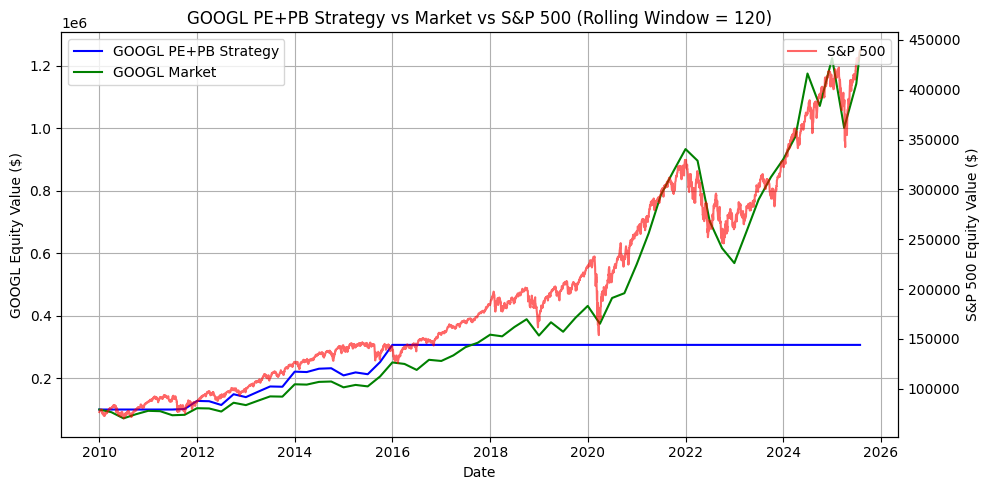

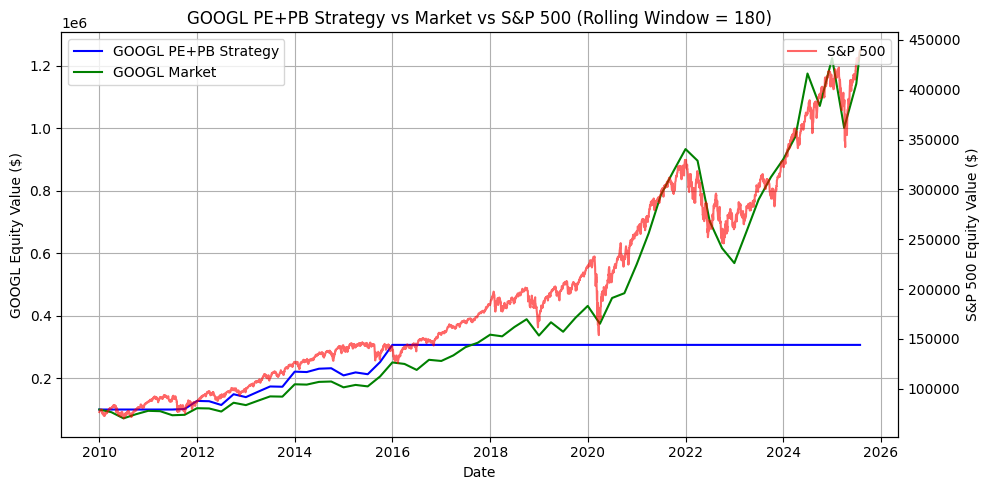

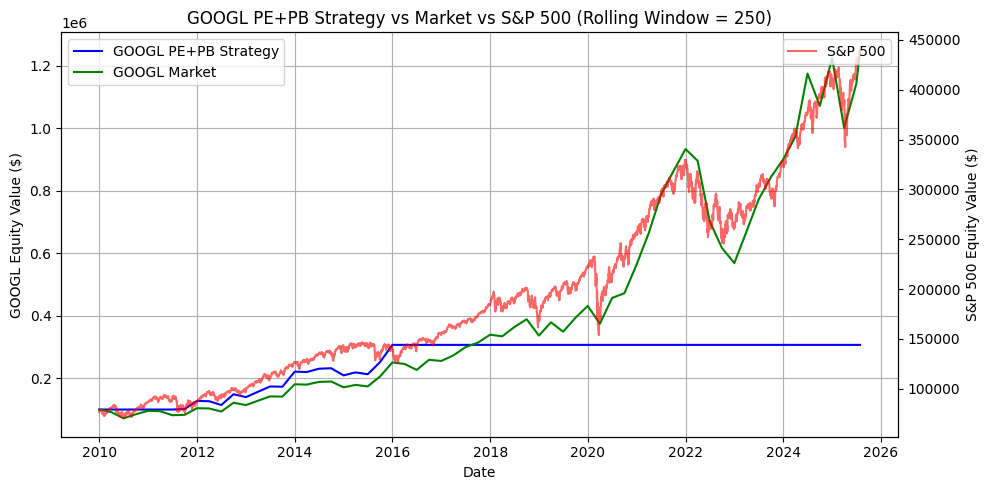

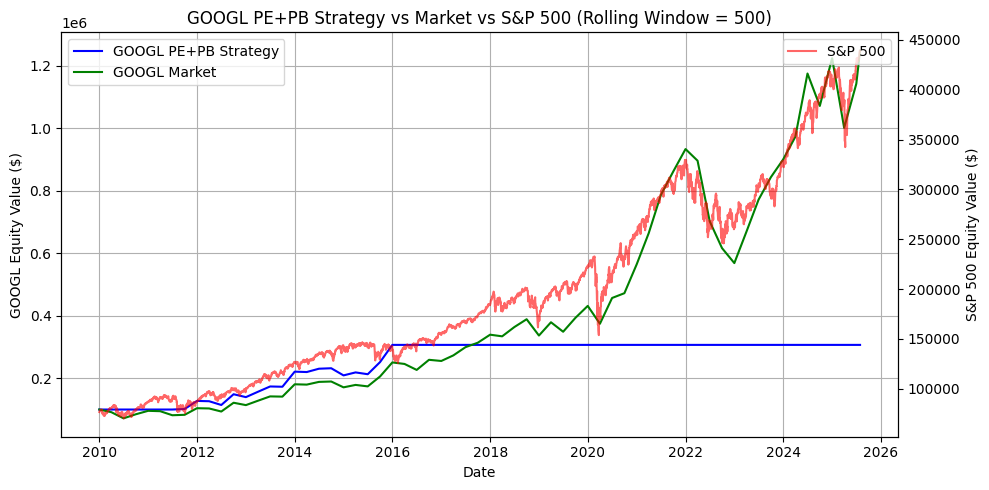

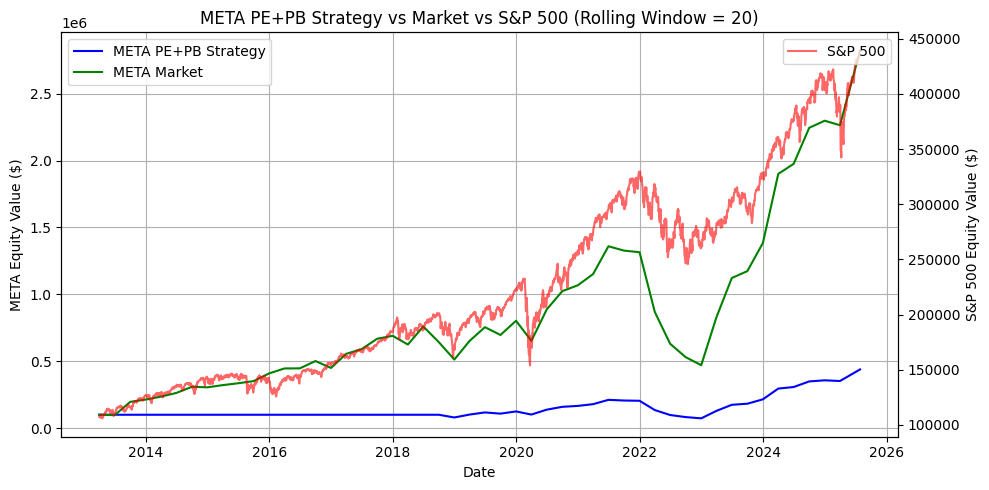

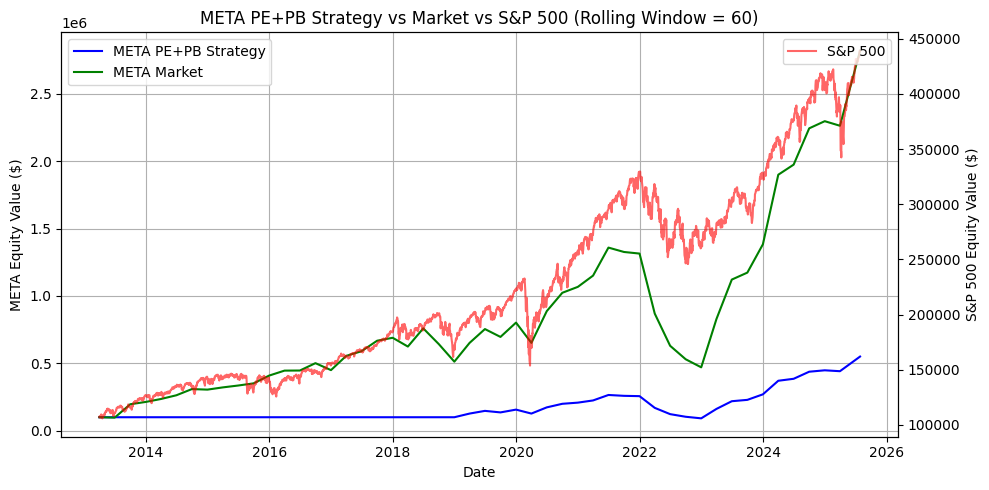

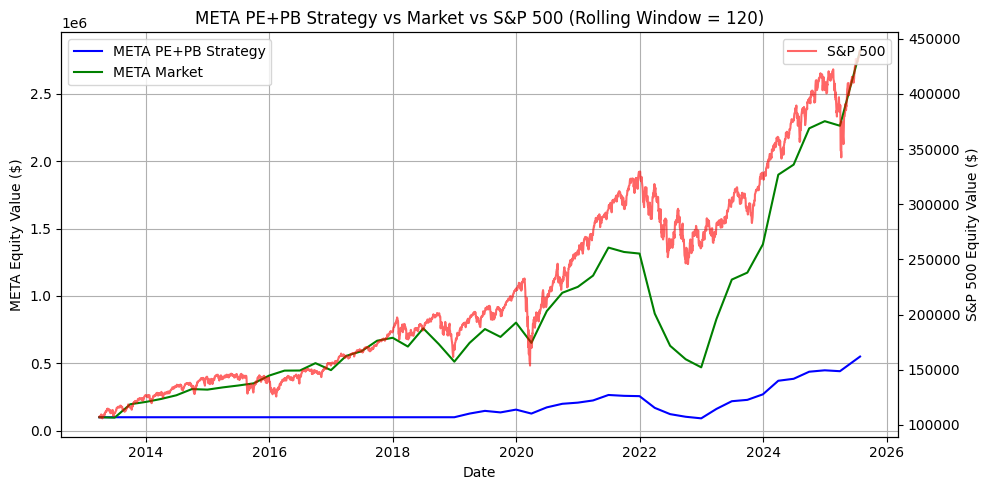

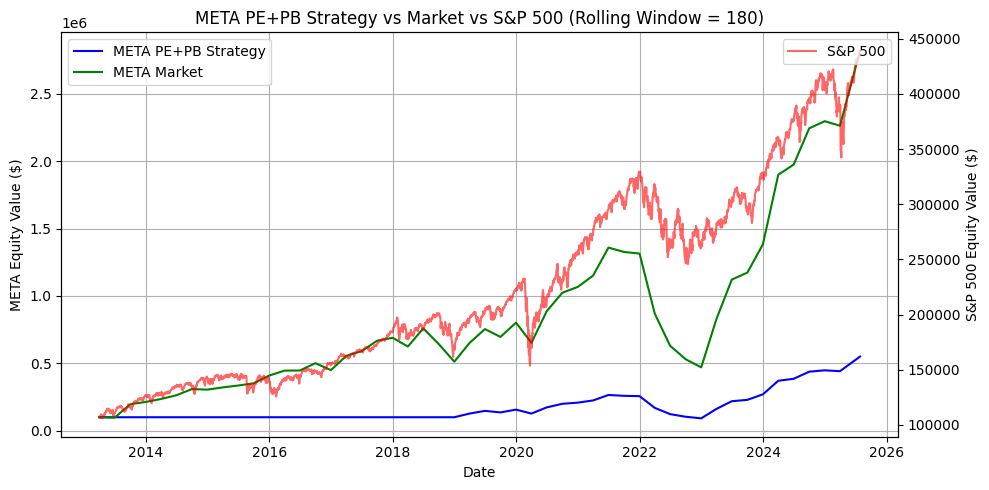

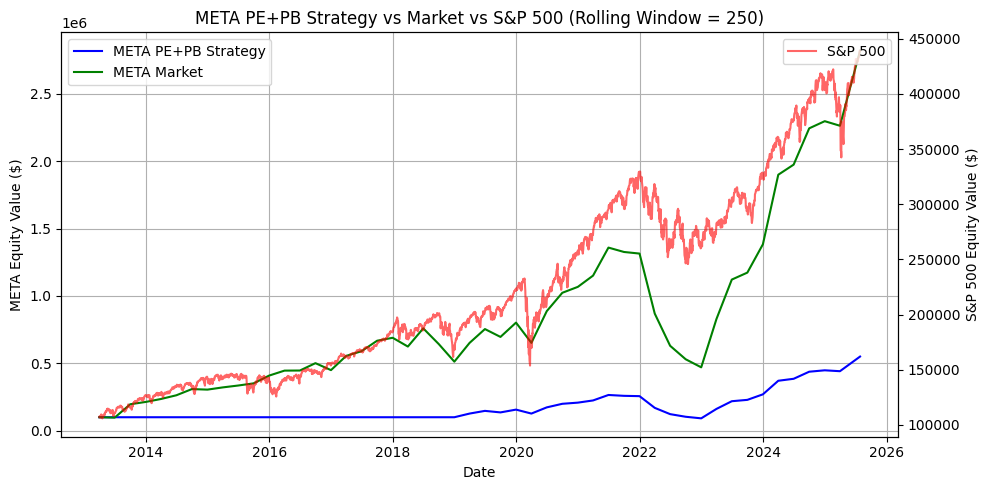

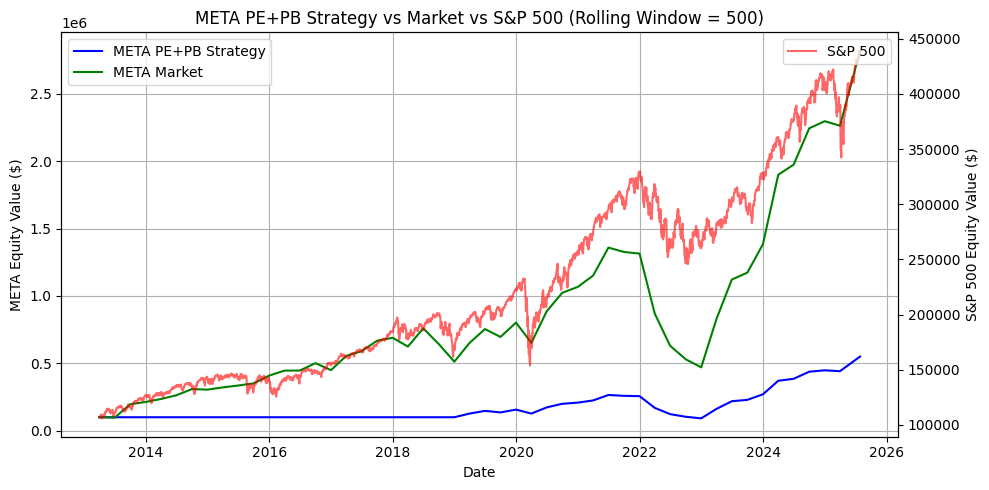

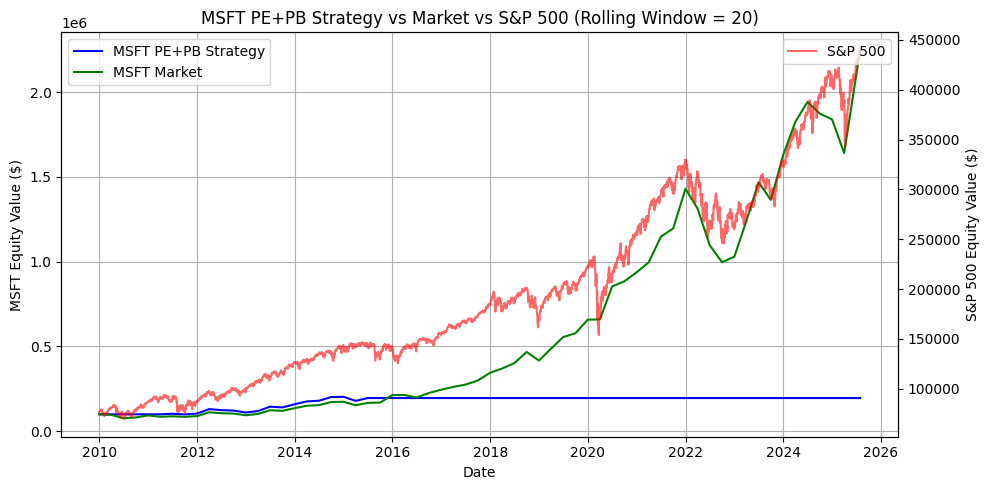

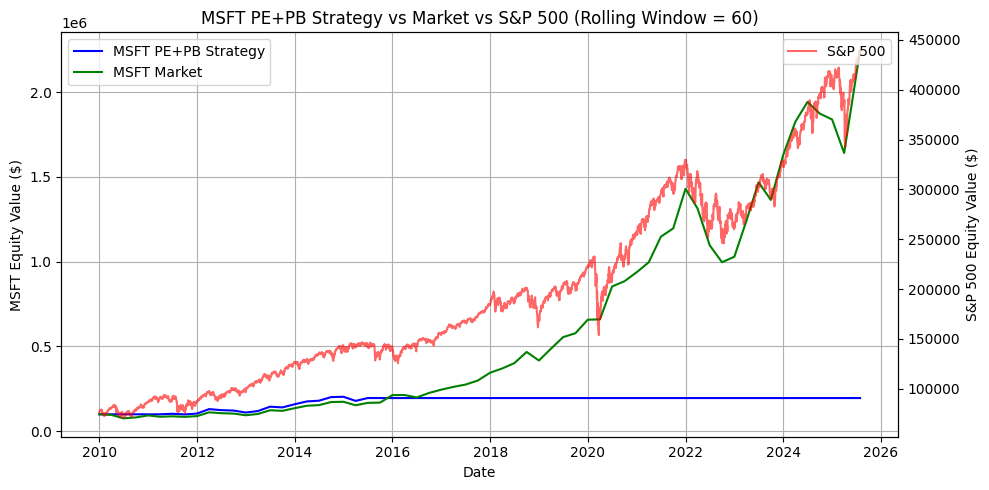

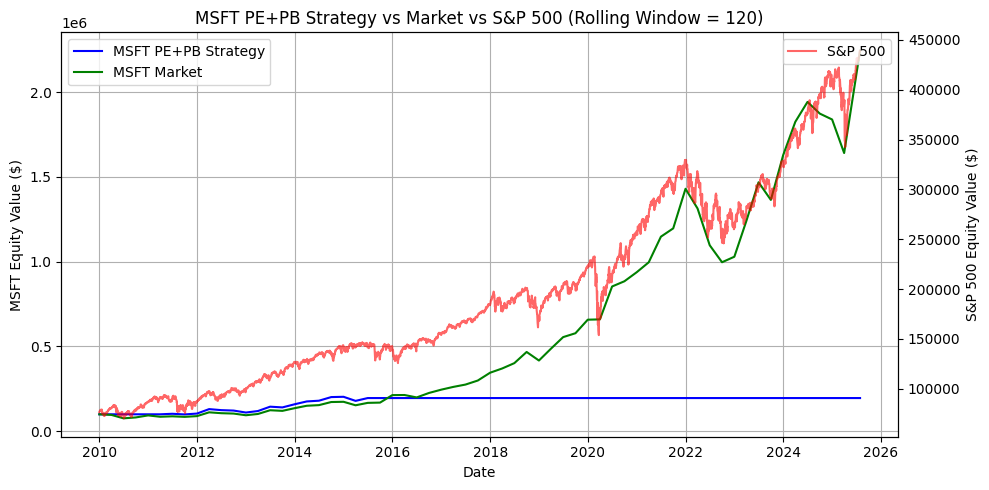

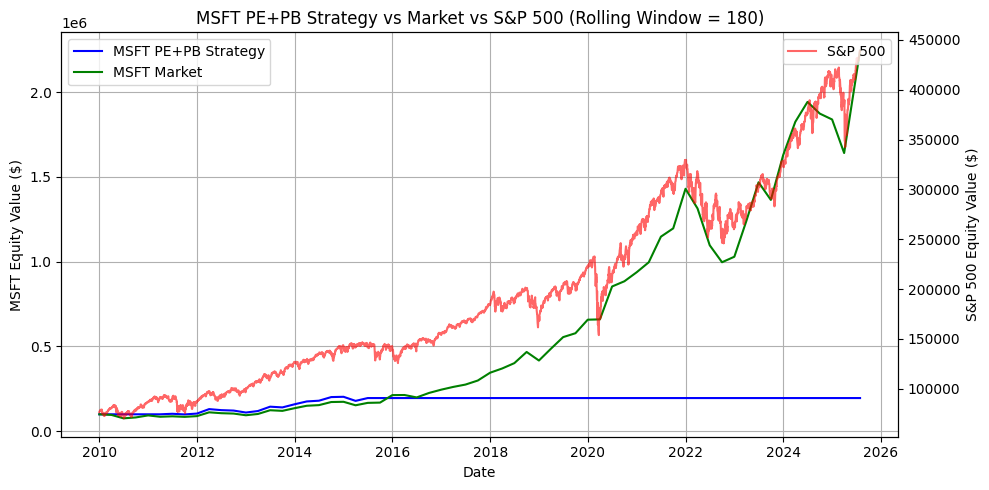

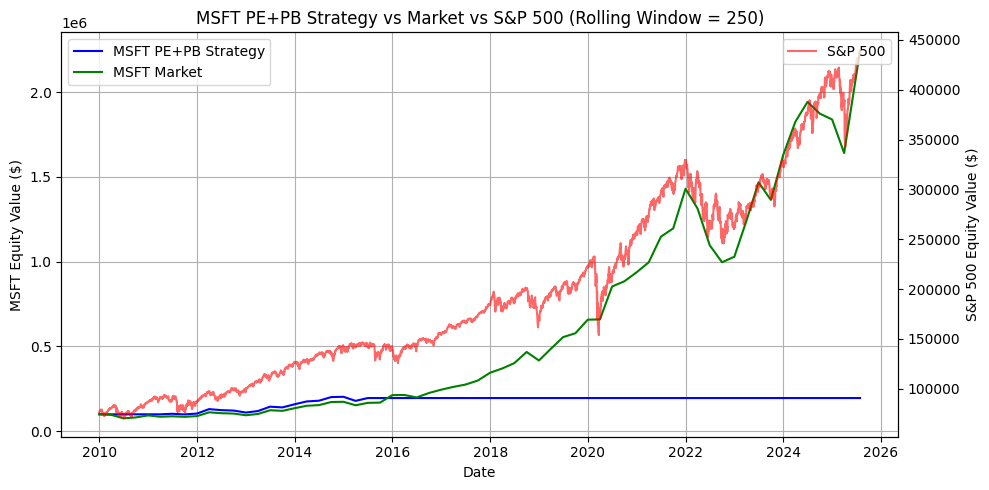

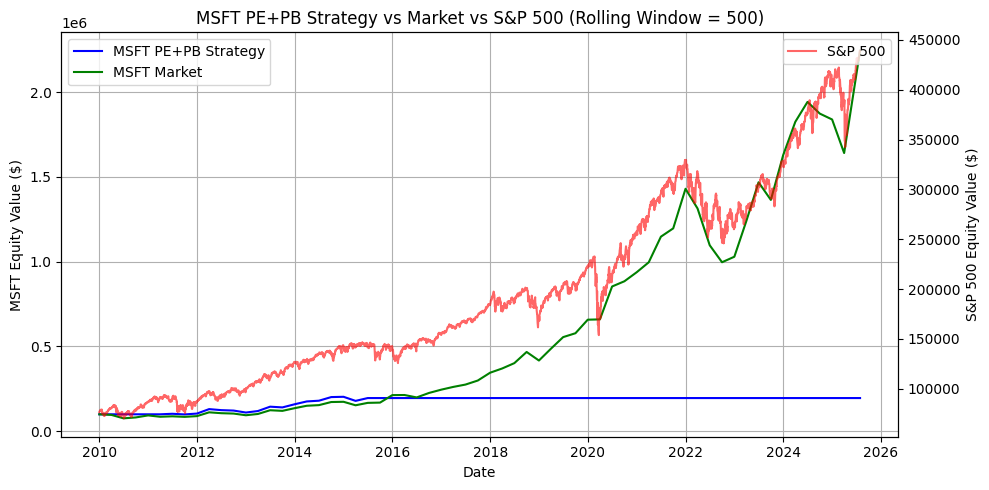

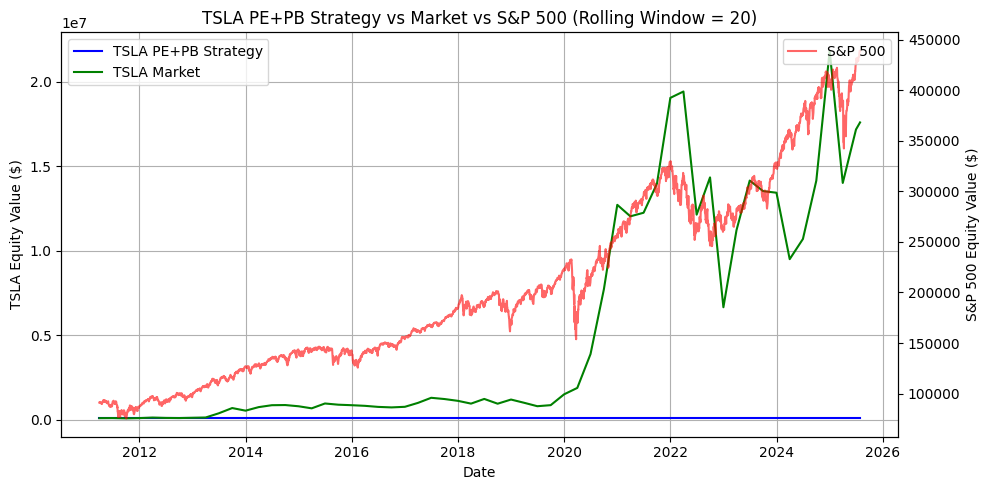

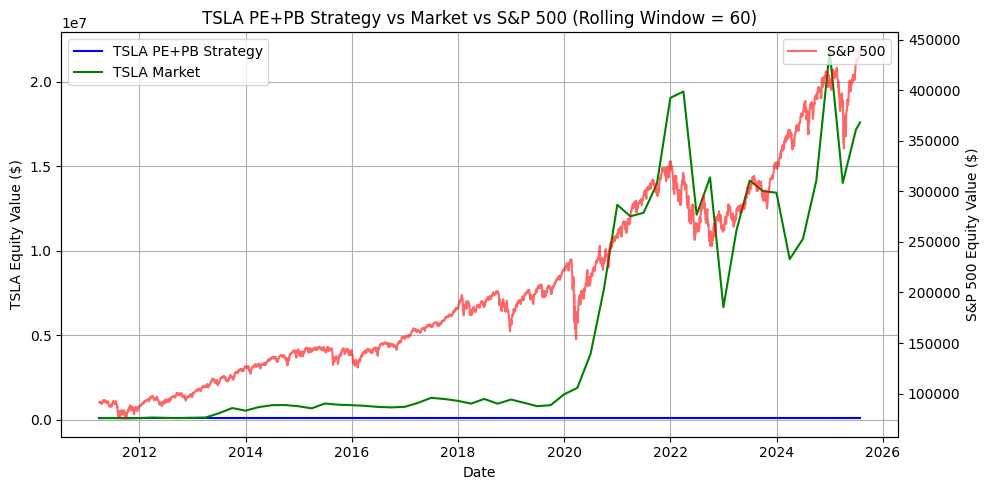

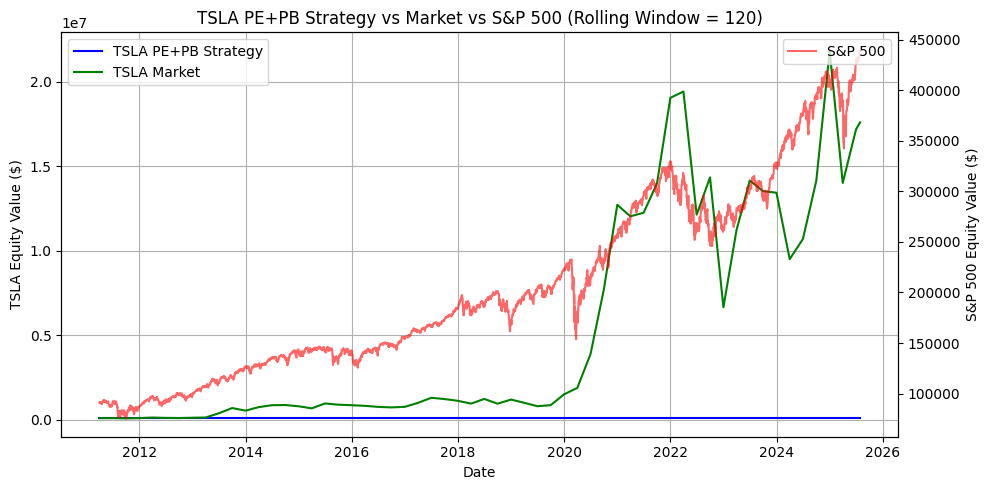

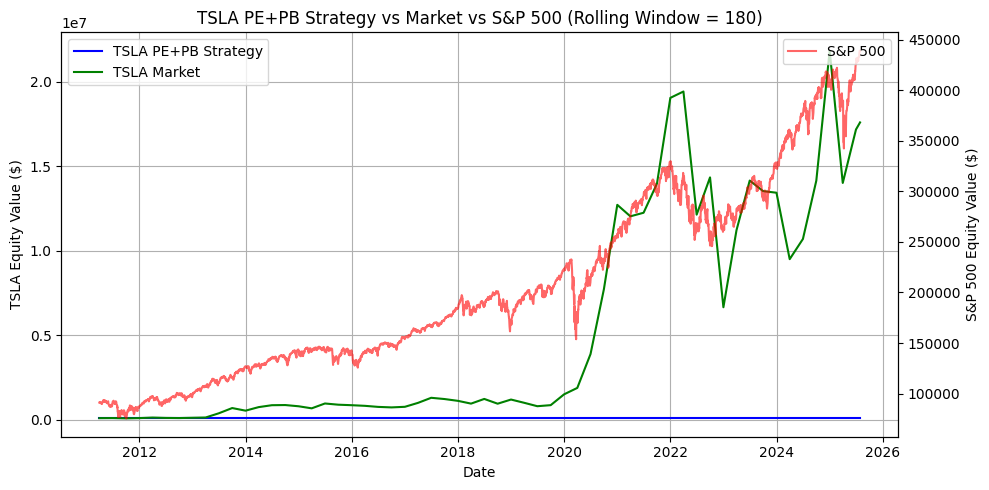

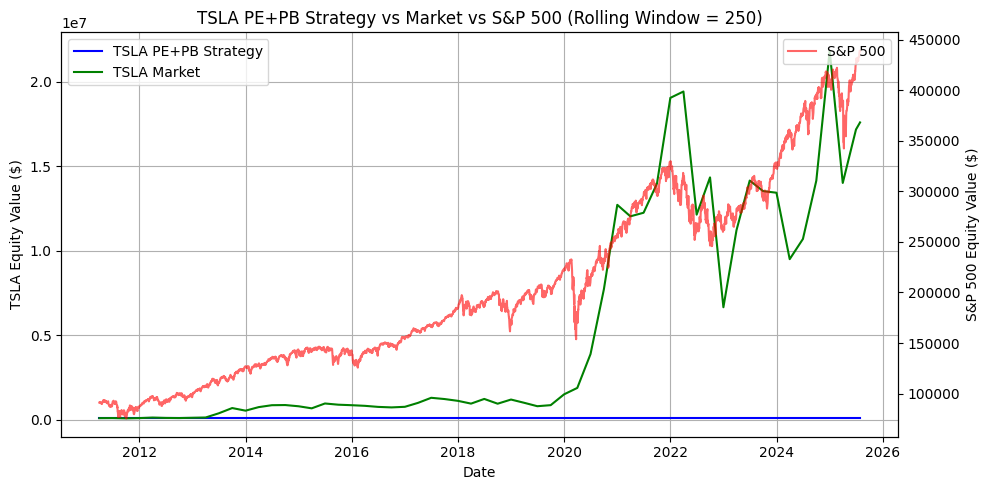

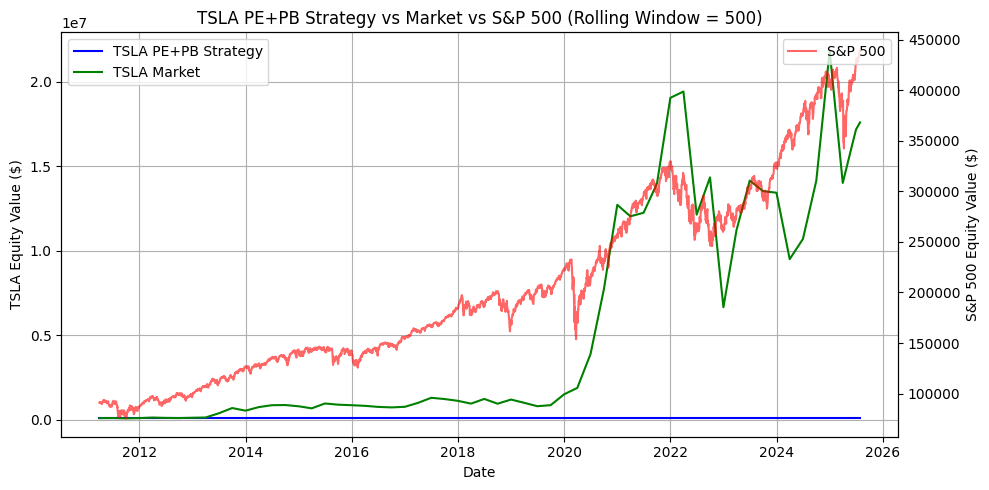

In [19]:
for ticker in tickers:
    for window in rolling_windows:
        temp = df[(df['TickerName'] == ticker) & (df['RollingWindow'] == window)].copy()
        temp = temp.sort_values('Date').reset_index(drop=True)

        if 'StockPrice_x' in temp.columns:
            temp['StockPrice'] = temp['StockPrice_x']
        elif 'StockPrice_y' in temp.columns:
            temp['StockPrice'] = temp['StockPrice_y']
        else:
            raise KeyError(f"No 'StockPrice' column found for ticker {ticker} and window {window}")

        temp.drop(columns=['StockPrice_x', 'StockPrice_y'], inplace=True, errors='ignore')

        temp['Return'] = temp['StockPrice'].pct_change().fillna(0)

        temp['Position'] = 0
        holding = False
        for i in range(1, len(temp)):
            if temp.loc[i-1, 'Signal'] == 1:
                holding = True
            elif temp.loc[i-1, 'Signal'] == -1:
                holding = False
            temp.loc[i, 'Position'] = 1 if holding else 0

        temp['Strategy_Return'] = temp['Return'] * temp['Position']
        temp['Cumulative_Strategy'] = (1 + temp['Strategy_Return']).cumprod()
        temp['Cumulative_Market'] = (1 + temp['Return']).cumprod()

        temp['Strategy_Equity'] = initial_capital * temp['Cumulative_Strategy']
        temp['Market_Equity'] = initial_capital * temp['Cumulative_Market']

        sp500_sub = sp500[(sp500['Date'] >= temp['Date'].min()) & (sp500['Date'] <= temp['Date'].max())].copy()
        sp500_sub = sp500_sub.reset_index(drop=True)

        fig, ax1 = plt.subplots(figsize=(10, 5))

        ax1.plot(temp['Date'], temp['Strategy_Equity'], label=f'{ticker} PE+PB Strategy', color='blue')
        ax1.plot(temp['Date'], temp['Market_Equity'], label=f'{ticker} Market', color='green')
        ax1.set_xlabel('Date')
        ax1.set_ylabel(f'{ticker} Equity Value ($)')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(sp500_sub['Date'], sp500_sub['SP500_Curve'], label='S&P 500', color='red', alpha=0.6)
        ax2.set_ylabel('S&P 500 Equity Value ($)')
        ax2.legend(loc='upper right')

        plt.title(f'{ticker} PE+PB Strategy vs Market vs S&P 500 (Rolling Window = {window})')
        plt.tight_layout()
        plt.show()
